In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
from helper import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.decomposition import PCA
import datetime
from sklearn.linear_model import LogisticRegression

In [2]:
data_folder = 'dataset/'
categories_list = ['isFraud']+['id_'+str(x) for x in range(12,39)]+['DeviceInfo','DeviceType','R_emaildomain','P_emaildomain','addr1','addr2','ProductCD'] + ['M'+str(x) for x in range(1,10)] + ['card'+str(x) for x in range(1,7)]+['Hours','Days']

So, the code from kaggle's IEEE challenge was downloaded as CSV, merged and saved as pickle. Uncomment the below lines to merge and save as pickle. 

In [3]:
#train_transaction = pd.read_csv(data_folder+'train_transaction.csv')
#train_identity = pd.read_csv(data_folder+'train_identity.csv')
#test_transaction = pd.read_csv(data_folder+'test_transaction.csv')
#test_identity = pd.read_csv(data_folder+'test_identity.csv')
#train = reduce_memory_usage(train_transaction.merge(train_identity, how='left', left_index=True, right_index=True, on='TransactionID'), categories=categories_list)
#test = reduce_memory_usage(test_transaction.merge(test_identity, how='left', left_index=True, right_index=True, on='TransactionID'),categories=categories_list)
#train.to_pickle(data_folder+'train.pkl')
#test.to_pickle(data_folder+'test.pkl')

Run the below code if pickle files of the dataset are available

In [4]:
train = pd.read_pickle(data_folder+'train.pkl')
test = pd.read_pickle(data_folder+'test.pkl')

Making a copy so as to avoid making mistakes on the main dataset

In [5]:
Ttrain = train.copy()
Ttest = test.copy()

In [6]:
train_target = pd.DataFrame()
test_target = pd.DataFrame()

In [7]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
Ttrain['Date'] = Ttrain['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
Ttest['Date'] = Ttest['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
Ttrain['Hours'] = assign_category(Ttrain['Date'].dt.hour)
Ttest['Hours'] = assign_category(Ttest['Date'].dt.hour)
Ttrain['Days'] = assign_category(Ttrain['Date'].dt.dayofweek)
Ttest['Days'] = assign_category(Ttest['Date'].dt.dayofweek)

In [8]:
Ttrain['logTAmt'] = np.log(Ttrain['TransactionAmt'])
Ttest['logTAmt'] = np.log(Ttest['TransactionAmt'])
train_target['logTAmt'] = Ttrain['logTAmt']
test_target['logTAmt'] = Ttest['logTAmt']

If you look below, the transaction amount has a distribution with large variance, to reduce it i.e. to handle large and small values together into our problem, a logarithm sounds good

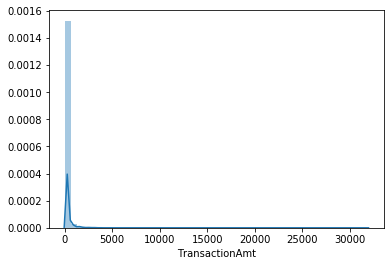

In [9]:
sns.distplot(Ttrain['TransactionAmt'])

The logarithmic plot has a low variance and high and low transaction amounts can be represented within this low variance

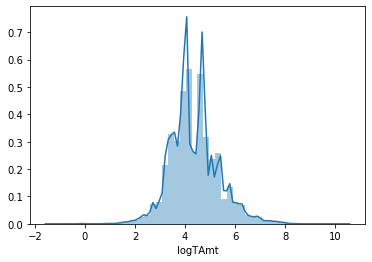

In [10]:
sns.distplot(Ttrain['logTAmt'])

Now let'S summarize a couple of next columns

In [11]:
categories = categories_list[1:]
summarize(Ttest[categories])

Dataset Shape: (506691, 51)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id_12,category,0,3,NotFound,Found,NotFound,1.02
1,id_13,category,0,28,27,Unavailable,52,1.20
2,id_14,category,0,28,Unavailable,-300,-360,0.84
3,id_15,category,0,4,New,Found,New,1.20
4,id_16,category,0,3,NotFound,Found,NotFound,1.06
5,id_17,category,0,104,225,166,225,1.19
6,id_18,category,0,18,15,Unavailable,Unavailable,0.66
7,id_19,category,0,503,427,542,271,2.28
8,id_20,category,0,437,563,368,507,2.33
9,id_21,category,0,444,Unavailable,Unavailable,Unavailable,0.13


In [12]:
category_means={}

for elem in categories:
    train_dct = calc_group_mean(df=Ttrain,group_of=elem,mean_of='logTAmt')
    test_dct = calc_group_mean(df=Ttest,group_of=elem,mean_of='logTAmt')
    category_means[elem] = {**test_dct, **train_dct}

In [13]:
for elem in categories:
    train_target[elem] = Ttrain['logTAmt']-map_to_groups(df=Ttrain,group_of=elem,map_dict=category_means[elem],convert_type=np.float32)
    test_target[elem] = Ttest['logTAmt']-map_to_groups(df=Ttest,group_of=elem,map_dict=category_means[elem],convert_type=np.float32)

In [14]:
summarize(test_target[['card5']])

Dataset Shape: (506691, 1)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card5,float32,0,31653,-0.984823,-0.557174,0.692669,10.26


In [15]:
summarize(Ttest[['logTAmt']])

Dataset Shape: (506691, 1)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,logTAmt,float32,0,14119,3.464172,3.89182,5.141664,8.08


In [16]:
map_to_groups(df=Ttest,group_of='card5',map_dict=category_means[elem],convert_type=np.float32).isnull().sum()

506691

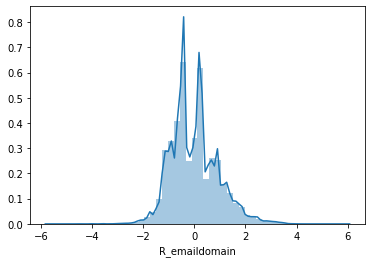

In [17]:
sns.distplot(train_target['R_emaildomain'])

In [18]:
non_categories_C = ['C'+str(i) for i in range(1,15)]
non_categories_D = ['D'+str(i) for i in range(1,16)]
non_categories_V = ['V'+str(i) for i in range(1,340)]
non_categories_id = ['id_0'+str(i) for i in range(1,10)]+['id_10','id_11']
continuous = non_categories_C+non_categories_D+non_categories_V+non_categories_id

In [19]:
continuous_summary = summarize(Ttrain[continuous])

Dataset Shape: (590540, 379)


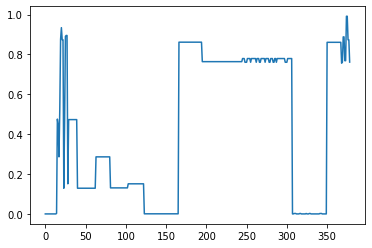

In [20]:
plt.plot(continuous_summary['Missing']/Ttrain.shape[0])

In [21]:
summarize(Ttest[continuous])

Dataset Shape: (506691, 379)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float32,3,1174,6.0,3.0,2.0,2.68
1,C2,float32,3,1123,6.0,2.0,2.0,2.76
2,C3,float32,3,31,0.0,0.0,0.0,0.18
3,C4,float32,3,728,0.0,0.0,0.0,1.21
4,C5,float32,3,353,3.0,0.0,0.0,1.93
...,...,...,...,...,...,...,...,...
374,id_07,float32,501632,81,NaN,NaN,NaN,5.38
375,id_08,float32,501632,90,NaN,NaN,NaN,5.63
376,id_09,float32,432353,38,NaN,0.0,NaN,0.50
377,id_10,float32,432353,52,NaN,0.0,NaN,0.29


In [22]:
considered_cont, nonconsidered_cont = ignore_categories_nan(threshold=0.4,df=Ttrain,categories=continuous)

In [23]:
considered_cont_Train_df, min_max_train_dct = min_max_scale(df=Ttrain,categories=considered_cont)
considered_cont_Test_df, _ = min_max_scale(df=Ttest,categories=considered_cont, min_max_dict=min_max_train_dct)

In [24]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(considered_cont_Train_df)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [25]:
imputed_continuous_train = pd.DataFrame(imputer.transform(considered_cont_Train_df),columns=considered_cont)
imputed_continuous_test = pd.DataFrame(imputer.transform(considered_cont_Test_df),columns=considered_cont)

In [26]:
n_components = 80
new_sols = ['cont'+str(i) for i in range(n_components)]
pca_cont = PCA(n_components=n_components)
pca_cont.fit(imputed_continuous_train)
train_new_cont = pd.DataFrame(pca_cont.transform(imputed_continuous_train),columns = new_sols)
test_new_cont = pd.DataFrame(pca_cont.transform(imputed_continuous_test),columns = new_sols)

In [27]:
train_target_wo_date = train_target.merge(train_new_cont, how='left',left_index=True,right_index=True)
test_target_wo_date = test_target.merge(test_new_cont, how='left',left_index=True,right_index=True)

In [28]:
train_target['Hours'] = Ttrain['Hours']
train_target['Days'] = Ttrain['Days']
test_target['Hours'] = Ttest['Hours']
test_target['Days'] = Ttest['Days']

In [29]:
training_labels = Ttrain['isFraud']

In [30]:
regressor = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=500).fit(train_target, training_labels)
predictions_regressor = regressor.predict(test_target)

/home/lad/Documents/IEEE-CIS-fraud-detection/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [31]:
regressordf = pd.DataFrame()
regressordf['TransactionID'] = Ttest['TransactionID']
regressordf['isFraud'] = predictions

In [32]:
regressordf.to_csv(data_folder+'RSL_regressor.csv', index=False)

In [39]:
from sklearn import tree
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier= tree_classifier.fit(train_target, training_labels)

In [43]:
result_tree = pd.DataFrame()
pred_tree = tree_classifier.predict(test_target)
result_tree['TransactionID'] = Ttest['TransactionID']
result_tree['isFraud'] = pred_tree

In [44]:
result_tree.to_csv(data_folder+'RSL_submission_tree.csv', index=False)

In [45]:
summarize(result_tree[['isFraud']])

Dataset Shape: (506691, 1)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int64,0,2,0,1,0,0.25


In [48]:
pca_2 = PCA(n_components=2)
pca_2.fit(train_target)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [49]:
train_target_2 = pca_2.transform(train_target)
test_target_2 = pca_2.transform(test_target)

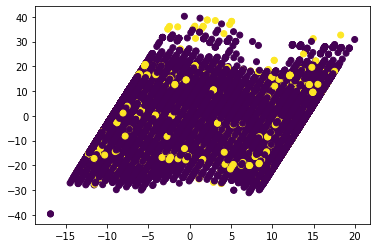

In [54]:
plt.scatter(train_target_2[:,0],train_target_2[:,1],c=Ttrain['isFraud'])

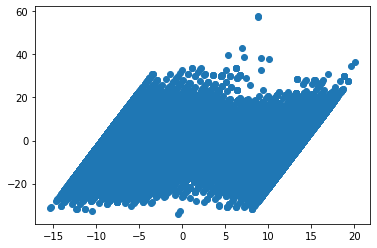

In [55]:
plt.scatter(test_target_2[:,0],test_target_2[:,1])